Ashok: on .182 , use nlp_1 conda env

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from pipeline import prepare_data, task1_entailment,task2_evidence

/home/pikachu/anaconda3/envs/nlp_1/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
# task1_entailment.train(model_name)
# task2_evidence.train(model_name)

# picking the misclassified examples

In [4]:
from pipeline.prepare_data import generate_nli_data
from pipeline.task1_entailment import CtDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# trained model checkpoint
model_nli_path = "storage/model-nli"
DEV_PATH = "data/dev.json"


# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_nli_path, model_max_length=1024)
model = AutoModelForSequenceClassification.from_pretrained(model_nli_path,
                                num_labels=2, ignore_mismatched_sizes=True)


joint_dev, labels_dev= generate_nli_data(DEV_PATH)

encoded_dev = tokenizer(joint_dev, return_tensors='pt',
                        truncation_strategy='only_first', add_special_tokens=True, padding=True)
dev_dataset = CtDataset(encoded_dev, labels_dev)


/home/pikachu/anaconda3/envs/nlp_1/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2421: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  FutureWarning,


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

incorrect_sample_ids = []

N_SAMPLES = 200
# checks the first N_SAMPLES samples; len(dev_dataset) = 200
for i in range(N_SAMPLES):
    one_sample = dev_dataset[i]
    input_ids = one_sample['input_ids'].unsqueeze(0).to(device)
    attention_mask = one_sample['attention_mask'].unsqueeze(0).to(device)
    label = one_sample['labels'].unsqueeze(0).to(device)

    model.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        pred = logits.argmax(dim=1)
        # print(pred, label)
        if pred != label:
            incorrect_sample_ids.append(i)
            
        

In [9]:
# saveing the incorrect sample ids. so that i dont have to run the above code again
incorrect_sample_ids = "5 6 8 12 18 25 30 34 48 68 71 76 81 87 91 96 103 108 109 110 116 125 127 128 138 157 162 165 166 167 168 170 177 181 183 189 190 195".split()
incorrect_sample_ids = [int(i) for i in incorrect_sample_ids]

print(*incorrect_sample_ids)

5 6 8 12 18 25 30 34 48 68 71 76 81 87 91 96 103 108 109 110 116 125 127 128 138 157 162 165 166 167 168 170 177 181 183 189 190 195


In [ ]:
for idx in incorrect_sample_ids:
    claim, premise = joint_dev[idx].split("[SEP]")
    #inverse of the label mapping
    label = "Entailment" if labels_dev[idx] == 1 else "Contradiction"
    
    print(f"claim: \n{claim} \n\npremise: \n{premise} \nlabel: {label}")
    print("-"*50)
    # break

claim: 
only patients with a HER2-positive status can take part in the primary trial  

premise: 
 primary trial:   HER2-positive status (patients who have unknown HER2 status, and for whom determination of HER2 status is not possible, are eligible for this study).  
label: Contradiction
--------------------------------------------------
claim: 
the shortest PFS in cohort 1 of the primary trial was under 7 months, in cohort 2 the shortest was just over 7 months  

premise: 
 primary trial: Outcome Measurement:    Progression-Free Survival (PFS)   Progression-free survival will be measured from Day 1 of study drug administration to disease progression defined by Response Evaluation Criteria in Solid Tumors Criteria (RECIST v1.1) as a 20% increase in the sum of the longest diameter of target lesions, or a measurable increase in a non-target lesion, or the appearance of new lesions   Time frame: every 8 weeks until progressive disease, expected average of 18 months Results 1:    Arm/Group

## check the distribution on section_id's and types

In [23]:
sections, types = generate_nli_data(DEV_PATH,return_sections_types=True)

# count the number of incorrect samples in each section
incorrect_sections = {}
for idx in incorrect_sample_ids:
    section = sections[idx]
    incorrect_sections[section] = incorrect_sections.get(section, 0) + 1
print(incorrect_sections)

#count the number of incorrect samples in each type
incorrect_types = {}
for idx in incorrect_sample_ids:
    type_ = types[idx]
    incorrect_types[type_] = incorrect_types.get(type_, 0) + 1
print(incorrect_types)



returning sections and types
{'Eligibility': 7, 'Results': 13, 'Adverse Events': 14, 'Intervention': 4}
{'Single': 26, 'Comparison': 12}


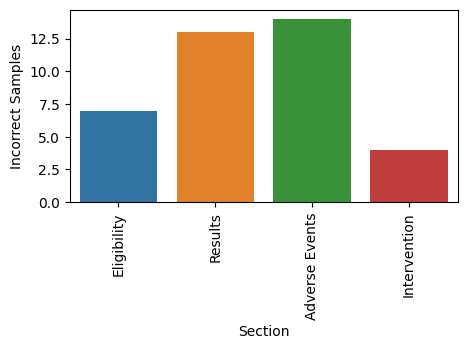

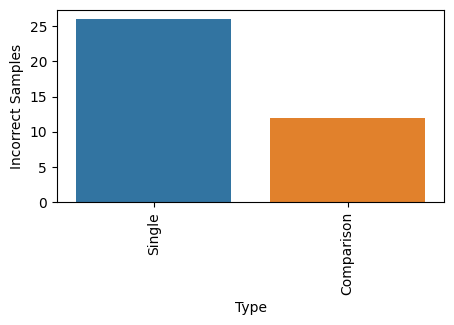

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.DataFrame(list(incorrect_sections.items()), columns=["Section", "Incorrect Samples"])

plt.figure(figsize=(5, 2.5))
sns.barplot(x="Section", y="Incorrect Samples", data=df)
plt.xticks(rotation=90)
plt.show()


df = pd.DataFrame(list(incorrect_types.items()), columns=["Type", "Incorrect Samples"])
plt.figure(figsize=(5, 2.5))
sns.barplot(x="Type", y="Incorrect Samples", data=df)
plt.xticks(rotation=90)
plt.show()

In [37]:
# compare the ratio of sections in devset and incorrect samples
sections_count_in_dev = {}
for section in sections:
    sections_count_in_dev[section] = sections_count_in_dev.get(section, 0) + 1
print(sections_count_in_dev)

types_count_in_dev = {}
for type_ in types:
    types_count_in_dev[type_] = types_count_in_dev.get(type_, 0) + 1
    
print(types_count_in_dev, end="\n\n")


print("Ratios for sections \n---------------")
for section in sections_count_in_dev:
    print(section,":" , incorrect_sections.get(section, 0)/sections_count_in_dev[section])
    
print("\nRatios for types \n-----------------")
for type_ in types_count_in_dev:
    print(type_, ":", incorrect_types.get(type_, 0)/types_count_in_dev[type_])

{'Results': 56, 'Eligibility': 56, 'Adverse Events': 52, 'Intervention': 36}
{'Single': 140, 'Comparison': 60}

Ratios for sections 
---------------
Results : 0.23214285714285715
Eligibility : 0.125
Adverse Events : 0.2692307692307692
Intervention : 0.1111111111111111

Ratios for types 
-----------------
Single : 0.18571428571428572
Comparison : 0.2


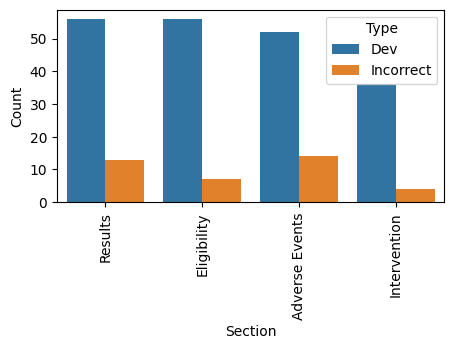

In [38]:
 # plot both in same graph overlayed
df = pd.DataFrame(list(sections_count_in_dev.items()), columns=["Section", "Count"])
df["Type"] = "Dev"
df2 = pd.DataFrame(list(incorrect_sections.items()), columns=["Section", "Count"])
df2["Type"] = "Incorrect"
df = pd.concat([df, df2])

plt.figure(figsize=(5, 2.5))
sns.barplot(x="Section", y="Count", data=df, hue="Type")
plt.xticks(rotation=90)
plt.show()

# df = pd.DataFrame(list(types_count_in_dev.items()), columns=["Type", "Count"])
# df["Type"] = "Dev"
# df2 = pd.DataFrame(list(incorrect_types.items()), columns=["Type", "Count"])
# df2["Type"] = "Incorrect"
# df = pd.concat([df, df2])

# plt.figure(figsize=(5, 2.5))
# sns.barplot(x="Type", y="Count", data=df, hue="Type")
# plt.xticks(rotation=90)
# plt.show()
